<a href="https://colab.research.google.com/github/TALeonard/19ma573thomasleonard/blob/master/src/hw11_btcs_stability_head_1d_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, import modules and define parameters as supplied.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl

In [0]:
'''=======
parameters
======='''

al = 1
dx = .2 #space mesh size
rho = 1. #conditinal number, to be less than .5 for the stability
dt = rho*(dx**2)/al #time step size

a = 0
b = 1
f = lambda x: np.sin(np.pi * x)
es = lambda x, t: np.exp(-1*(np.pi**2)*t) * np.sin(np.pi*x)
N = (b - a) / dx #Should be 5, given parameters.


Now, we need to use both FTCS and BTCS to solve this equation and find the supnorm of the error function.

For FTCS, we can utilize the same FTCS() code we used last week; for BTCS, a new code must be developed.

In [0]:
def heat_ftcs_err(dx,rho,al,exact_sol,phi,a,b,n):
  dt = rho*(dx**2)/al
  
  #Initialize with n = 0.
  j_0_linspace = np.linspace((a-n),(b+n),(b+n)-(a-n)+1)
  u_j_0 = np.zeros(len(j_0_linspace))
  for i in range(len(j_0_linspace)):
    u_j_0[i] = phi(j_0_linspace[i]*dx)
  
  #Initialize True Values Matrix.
  true_val = np.zeros(len(j_0_linspace))
  for j in range(len(j_0_linspace)):
    true_val[j] = exact_sol(j_0_linspace[j]*dx,0)
  
  #Initialize error vector, apply max error value for n = 0.
  max_error_vec = np.zeros(n+1)
  err_j_0 = (u_j_0 - true_val)
  max_error_vec[0] = max(abs(err_j_0))
  
  #Initialize approximation for n = 1, to use as first "u_j_(k-1)"
  j_1_linspace = np.linspace((a-(n-1)),(b+(n-1)),(b+(n-1))-(a-(n-1))+1)
  u_j_1 = np.zeros(len(j_1_linspace))
  for i in range(len(u_j_1)):
    j = i + 1
    u_j_1[i] = rho*u_j_0[j-1] + (1-2*rho)*u_j_0[j] + rho*u_j_0[j+1]
  
  u_j_k_minus_1 = u_j_1
  former_linspace = j_1_linspace
  
  #Find n = 1 max error for vector.
  true_val = np.zeros(len(j_1_linspace))
  for j in range(len(j_1_linspace)):
    true_val[j] = exact_sol(j_1_linspace[j]*dx,dt)
  err_j_1 = (u_j_1 - true_val)
  max_error_vec[1] = max(abs(err_j_1))
  
  #Perform iterative loop for all n >= 2.
  for k in range(2,n+1):
    #Create new linspace for u_j_k.
    new_linspace = np.linspace(a-(n-k),b+(n-k),(b+(n-k))-(a-(n-k))+1)
    u_j_k = np.zeros(len(new_linspace))
    
    #Iterate and fill u_j_k.
    for i in range(len(new_linspace)):
      j = i + 1
      u_j_k[i] = rho*u_j_k_minus_1[j-1] + (1 - 2*rho)*u_j_k_minus_1[j] + rho*u_j_k_minus_1[j+1]
    
    #Produce true values for comparison, and append to max vector.
    true_val = np.zeros(len(new_linspace))
    for i in range(len(new_linspace)):
      true_val[i] = exact_sol(new_linspace[i]*dx,k*dt)
    err_j_k = (u_j_k - true_val)
    max_error_vec[k] = max(abs(err_j_k))
    
    #Identify new values for former_linspace and u_j_(k-1), which allows us to
    #Continue the loop.
    former_linspace = new_linspace
    u_j_k_minus_1 = u_j_k
  
  true_err_max = max(max_error_vec)
  for i in range(len(max_error_vec)):
    if true_err_max == max_error_vec[i]:
      err_n = i
      
  return true_err_max, err_n, max_error_vec

In [17]:
output_1 = heat_ftcs_err(dx, rho, al, es, f, a, b, 5)
print("Supnorm of error for FTCS is " + str(output_1[0]))

Supnorm of error for FTCS is 0.06854713922733136


In [0]:
def heat_btcs_err(dx, rho, alpha, exact_sol, phi, a, b, n, m):
  dt = rho*(dx**2)/al
  
  # Initialize with for u_{j}^{0}.
  dx_linspace = np.linspace(a,b,int(b/dx)+1)

  u_j_0 = np.zeros(len(dx_linspace))
  for i in range(len(dx_linspace)):
    u_j_0[i] = phi(dx_linspace[i])
  
  # Initialize True Values Matrix.
  true_val = np.zeros(len(dx_linspace))
  for j in range(len(dx_linspace)):
    true_val[j] = exact_sol(dx_linspace[j],0)
  
  # Initialize error vector, apply max error value for n = 0.
  max_error_vec = np.zeros(m+1)
  err_j_0 = (u_j_0 - true_val)
  max_error_vec[0] = max(abs(err_j_0))
  
  # Initialize rho matrix, for use in solving.
  rho_matrix = np.zeros((len(dx_linspace),len(dx_linspace)))
  for i in range(len(dx_linspace)-1):
    if i == 0:
      pass
    else:
      rho_matrix[i,i-1] = -1*rho
      rho_matrix[i,i] = 1 + 2*rho
      rho_matrix[i,i+1] = -1*rho
  rho_matrix[0,0] = 1 + 2*rho
  rho_matrix[0,1] = -1*rho
  rho_matrix[len(dx_linspace)-1,len(dx_linspace)-2] = -1*rho
  rho_matrix[len(dx_linspace)-1,len(dx_linspace)-1] = 1 + 2*rho
  
  # "Solve" for u_j_1 using scipy.linalg.solve
  u_j_1 = sl.solve(rho_matrix,u_j_0)
  
  # Define u_j_1 as the first u_j_k_minus_1 for the for loop.
  u_j_k_minus_1 = u_j_1
  
  # Find n = 1 max error for vector.
  true_val = np.zeros(len(dx_linspace))
  for j in range(len(dx_linspace)):
    true_val[j] = exact_sol(dx_linspace[j],dt)
  err_j_1 = (u_j_1 - true_val)
  max_error_vec[1] = max(abs(err_j_1))
  
  # Perform iterative loop for all m >= 2.
  for k in range(2,m+1):
    # Fill u_j_k by scipy.linalg.solve().
    u_j_k = sl.solve(rho_matrix,u_j_k_minus_1)
    
    # Produce true values for comparison, and append to max vector.
    true_val = np.zeros(len(dx_linspace))
    for i in range(len(dx_linspace)):
      true_val[i] = exact_sol(dx_linspace[i],k*dt)
    err_j_k = (u_j_k - true_val)
    max_error_vec[k] = max(abs(err_j_k))
    
    # Identify new values for u_j_(k-1), which allows us to continue the loop.
    u_j_k_minus_1 = u_j_k
  
  true_err_max = max(max_error_vec)
  for i in range(len(max_error_vec)):
    if true_err_max == max_error_vec[i]:
      err_n = i
      
  return true_err_max, err_n, max_error_vec, err_j_k

In [90]:
x = np.linspace(0,1,int((1/dx))+1)
print(x)

[0.  0.2 0.4 0.6 0.8 1. ]


Consider going to time T = 1, which means that $0.04 = \frac{1}{m} \rightarrow m = 25$.

Also try $50, 75,$ and $100$ for comparison.

In [94]:
output_2 = heat_btcs_err(dx,rho,al,es,f,a,b,5,25)
print("Supnorm of error for BTCS to time 1 is " + str(output_2[0]))

output_3 = heat_btcs_err(dx,rho,al,es,f,a,b,5,50)
print("Supnorm of error for BTCS to time 2 is " + str(output_3[0]))

output_4 = heat_btcs_err(dx,rho,al,es,f,a,b,5,75)
print("Supnorm of error for BTCS to time 3 is " + str(output_4[0]))

output_5 = heat_btcs_err(dx,rho,al,es,f,a,b,5,100)
print("Supnorm of error for BTCS to time 4 is " + str(output_5[0]))

Supnorm of error for BTCS to time 1 is 0.19387399477467304
Supnorm of error for BTCS to time 2 is 0.19387399477467304
Supnorm of error for BTCS to time 3 is 0.19387399477467304
Supnorm of error for BTCS to time 4 is 0.19387399477467304


The error seems to peak. Interesting; this rho would have completely broken the FTCS. Either I've done something wrong, or BTCS doesn't have the same stability risk.

Now, we want error curves for $t = 1.94, 1.96, 1.98$. In order to get to these values, we need $k\Delta t = 1.94, 1.96, 1.98$. As $\Delta t = \frac{\rho(\Delta x)^{2}}{\alpha} = \frac{0.2^{2}}{1} = 0.04$, this becomes $k = \frac{1.94}{0.04}, \frac{1.96}{0.04}, \frac{1.98}{0.04} = 48.5, 49, 49.5$. Opt to use $n = 48, 49, 50$ as the "true" values, much like in Heat FTCS approximation.

Here, we don't need to worry about a decreasing bucket size as n increases (in the FTCS code, we were developing a pyramid that decreased in "width" as n increased so we had to go past the N we wanted in order to develop an approximation with a satisfactory set of numbers). The output here is essentially a vertical box, whose size never changes as N goes up or down. Thus, we can simply use these values of $n$ in the argument.

In [0]:
output_194 = heat_btcs_err(dx,rho,al,es,f,a,b,5,48)
output_196 = heat_btcs_err(dx,rho,al,es,f,a,b,5,49)
output_198 = heat_btcs_err(dx,rho,al,es,f,a,b,5,50)

Text(0.5, 0, 'x')

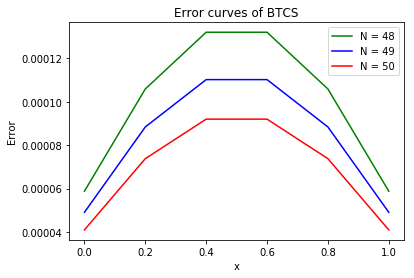

In [97]:
n_vec_1 = output_194[3]
x_lin = np.linspace(a,b,int(b/dx)+1)

n_vec_2 = output_196[3]

n_vec_3 = output_198[3]

plt.plot(x_lin,n_vec_1,'g',x_lin,n_vec_2,'b',x_lin,n_vec_3,'r')
plt.legend(["N = 48", "N = 49", "N = 50"])
plt.title("Error curves of BTCS")
plt.ylabel("Error")
plt.xlabel("x")

I don't really have any other analysis here but I will say that I find it interesting that the error is still decreasing here, despite how it'd be breaking massively in FTCS as of this point.